In [ ]:
import matplotlib.pyplot as plt
import tensorflow as tf
import tensorflow.keras.layers as layers
from tensorflow.keras.models import Model
import gc
import numpy as np

In [ ]:
(x_train, y_train), (x_test, y_test) = tf.keras.datasets.cifar10.load_data()


170498071/170498071 [==============================] - 13s 0us/step


In [ ]:
x_train.shape

(50000, 32, 32, 3)

In [ ]:
x_train = x_train/255.0
x_test = x_test/255.0

In [ ]:
input_1 = layers.Input(shape=(32, 32, 3))

# Encoder
x = layers.Conv2D(32, (3, 3), activation="relu", padding="same")(input_1)
x = layers.MaxPooling2D((2, 2), padding="same")(x)
x = layers.Conv2D(32, (3, 3), activation="relu", padding="same")(x)
x = layers.MaxPooling2D((2, 2), padding="same")(x)
x = layers.Conv2D(64, (3, 3), activation="relu", padding="same")(x)

latent = layers.Flatten()(x)



# Classification
stop_grad = layers.Lambda(lambda x: tf.keras.backend.stop_gradient(x))(latent)

classification_head = layers.Dense(512, activation='relu')(stop_grad)
classification_head = layers.Dropout(0.1)(classification_head)
classification_head = layers.Dense(256, activation='relu')(classification_head)
classification_head = layers.Dropout(0.1)(classification_head)

classification_head = layers.Dense(10, activation='softmax', name='classification_head')(classification_head)

# Decoder
d = layers.Reshape((4, 4, 64*4))(latent)
d = layers.Conv2DTranspose(64, (3, 3), strides=2, activation="relu", padding="same")(d)
d = layers.BatchNormalization()(d)
d = layers.Conv2DTranspose(32, (3, 3), strides=2, activation="relu", padding="same")(d)
d = layers.BatchNormalization()(d)
d = layers.Conv2DTranspose(32, (3, 3), strides=2, activation="relu", padding="same")(d)

decoded = layers.Conv2D(3, (3, 3), activation='sigmoid', padding='same', name='reconstruction_head')(d)

model = Model(inputs=[input_1], outputs=[decoded, classification_head], name='autoencoder')
encoder = Model(input_1, latent)
model.summary()

Model: "autoencoder"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_2 (InputLayer)           [(None, 32, 32, 3)]  0           []                               
                                                                                                  
 conv2d_3 (Conv2D)              (None, 32, 32, 32)   896         ['input_2[0][0]']                
                                                                                                  
 max_pooling2d_2 (MaxPooling2D)  (None, 16, 16, 32)  0           ['conv2d_3[0][0]']               
                                                                                                  
 conv2d_4 (Conv2D)              (None, 16, 16, 32)   9248        ['max_pooling2d_2[0][0]']        
                                                                                        

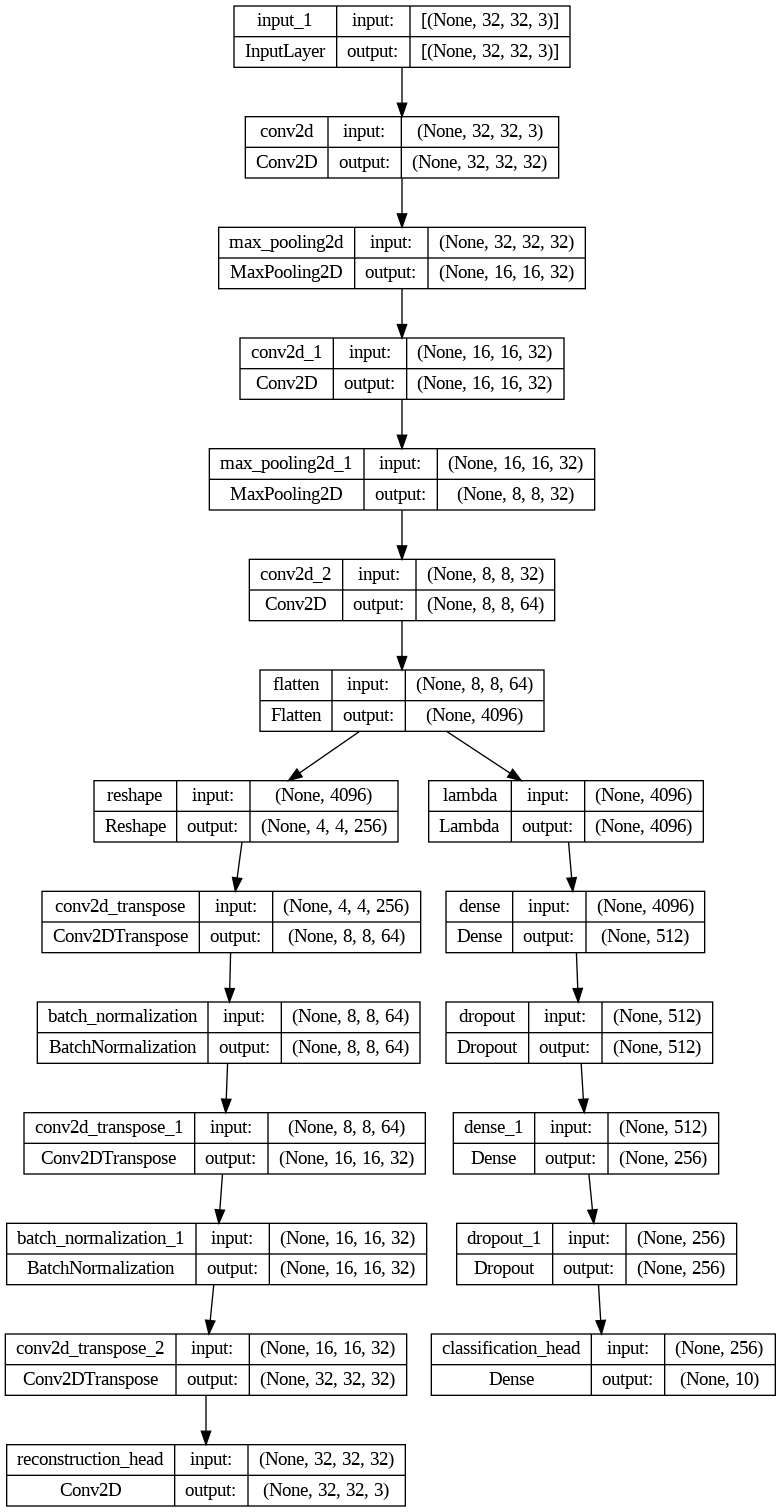

In [ ]:
from keras.utils.vis_utils import plot_model
plot_model(model, to_file='model_plot.png', show_shapes=True, show_layer_names=True)

In [ ]:
model.compile(
    optimizer="adam",
    loss={
        'reconstruction_head': 'binary_crossentropy',
        'classification_head': 'categorical_crossentropy'
    },
    metrics=['accuracy']
)

In [ ]:
y_tf = tf.keras.utils.to_categorical(y_train, num_classes = 10)


In [ ]:
gc.collect()

983

In [ ]:
h = model.fit(
    x=x_train,
    y={
        'reconstruction_head': x_train,
        'classification_head': y_tf
    },
    epochs=30,
    batch_size=128,
    shuffle=True,
    validation_split=0.05
)

Epoch 1/30
372/372 [==============================] - 10s 16ms/step - loss: 2.4296 - reconstruction_head_loss: 0.5891 - classification_head_loss: 1.8404 - reconstruction_head_accuracy: 0.5680 - classification_head_accuracy: 0.3310 - val_loss: 2.3425 - val_reconstruction_head_loss: 0.6323 - val_classification_head_loss: 1.7102 - val_reconstruction_head_accuracy: 0.4536 - val_classification_head_accuracy: 0.3928
Epoch 2/30
372/372 [==============================] - 5s 14ms/step - loss: 2.1363 - reconstruction_head_loss: 0.5715 - classification_head_loss: 1.5648 - reconstruction_head_accuracy: 0.6833 - classification_head_accuracy: 0.4357 - val_loss: 2.0703 - val_reconstruction_head_loss: 0.5743 - val_classification_head_loss: 1.4960 - val_reconstruction_head_accuracy: 0.6993 - val_classification_head_accuracy: 0.4640
Epoch 3/30
372/372 [==============================] - 5s 15ms/step - loss: 2.0138 - reconstruction_head_loss: 0.5682 - classification_head_loss: 1.4456 - reconstruction_head

In [ ]:
h.history

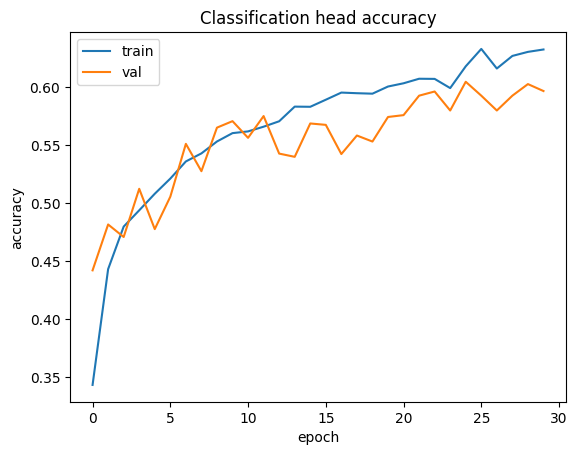

In [ ]:
from matplotlib import pyplot as plt
plt.plot(h.history['classification_head_accuracy'])
plt.plot(h.history['val_classification_head_accuracy'])
plt.title('Classification head accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'val'], loc='upper left')
plt.show()

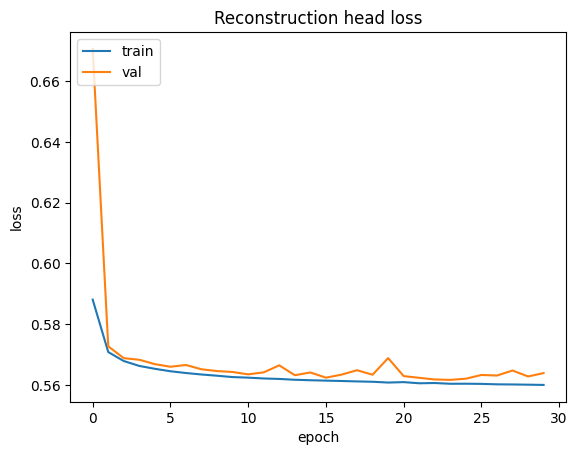

In [ ]:
from matplotlib import pyplot as plt
plt.plot(h.history['reconstruction_head_loss'])
plt.plot(h.history['val_reconstruction_head_loss'])
plt.title('Reconstruction head loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'val'], loc='upper left')
plt.show()

In [ ]:
y_pred = model.predict(x_test)

313/313 [==============================] - 1s 3ms/step


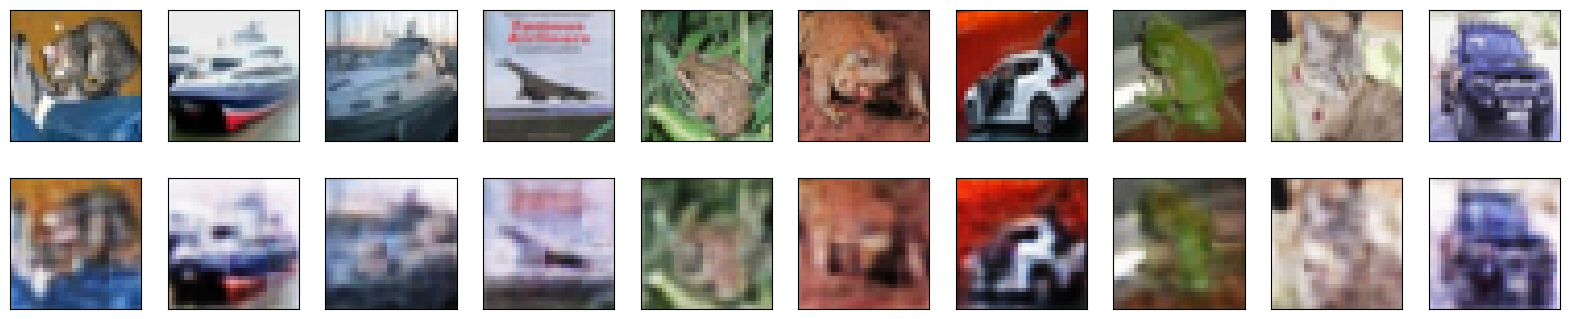

In [ ]:
def display(x1, x2):
    n = 10  # How many digits we will display
    plt.figure(figsize=(20, 4))
    for i in range(n):
        # Display original
        ax = plt.subplot(2, n, i + 1)
        plt.imshow(x1[i])
        ax.get_xaxis().set_visible(False)
        ax.get_yaxis().set_visible(False)

        # Display reconstruction
        ax = plt.subplot(2, n, i + 1 + n)
        plt.imshow(x2[0][i])
        ax.get_xaxis().set_visible(False)
        ax.get_yaxis().set_visible(False)
    plt.show()

display(x_test, y_pred)

In [ ]:
features = encoder(x_train[:20000])

In [ ]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score

clf = RandomForestClassifier(max_depth=10, random_state=0)
clf.fit(features, y_train[:20000].ravel())

In [ ]:
x_test.shape

(10000, 32, 32, 3)

In [ ]:
features_test = encoder(x_test)

In [ ]:
y_pred = clf.predict(features_test)

In [ ]:
accuracy_score(y_test, y_pred)

0.449

In [ ]:
pred = model.predict(x_test)

313/313 [==============================] - 1s 3ms/step


In [ ]:
pred[1].shape

(10000, 10)

In [ ]:
def onehot_to_label(x):
    labels = []
    for i in range(x.shape[0]):
        labels.append(np.argmax(x[i]))
    return labels

In [ ]:
accuracy_score(y_test, onehot_to_label(pred[1]))

0.5805

In [ ]:
def noise(array):
    """
    Adds random noise to each image in the supplied array.
    """

    noise_factor = 0.4
    noisy_array = array + noise_factor * np.random.normal(
        loc=0.0, scale=1.0, size=array.shape
    )

    return np.clip(noisy_array, 0.0, 1.0)


In [ ]:
noisy_x_train = noise(x_train)
noisy_x_test = noise(x_test)

In [ ]:
model.compile(
    optimizer="adam",
    loss={
        'reconstruction_head': 'binary_crossentropy',
        'classification_head': 'categorical_crossentropy'
    },
    metrics=['accuracy']
)

In [ ]:
y_tf = tf.keras.utils.to_categorical(y_train, num_classes = 10)


In [ ]:
gc.collect()

2631

In [ ]:
h = model.fit(
    x=noisy_x_train,
    y={
        'reconstruction_head': x_train,
        'classification_head': y_tf
    },
    epochs=30,
    batch_size=128,
    shuffle=True,
    validation_split=0.05
)

Epoch 1/30
372/372 [==============================] - 24s 20ms/step - loss: 2.5319 - reconstruction_head_loss: 0.5969 - classification_head_loss: 1.9351 - reconstruction_head_accuracy: 0.5668 - classification_head_accuracy: 0.2937 - val_loss: 2.3370 - val_reconstruction_head_loss: 0.5952 - val_classification_head_loss: 1.7418 - val_reconstruction_head_accuracy: 0.5976 - val_classification_head_accuracy: 0.3668
Epoch 2/30
372/372 [==============================] - 5s 13ms/step - loss: 2.2813 - reconstruction_head_loss: 0.5821 - classification_head_loss: 1.6992 - reconstruction_head_accuracy: 0.6103 - classification_head_accuracy: 0.3867 - val_loss: 2.2182 - val_reconstruction_head_loss: 0.5868 - val_classification_head_loss: 1.6314 - val_reconstruction_head_accuracy: 0.6309 - val_classification_head_accuracy: 0.4116
Epoch 3/30
372/372 [==============================] - 5s 14ms/step - loss: 2.1808 - reconstruction_head_loss: 0.5798 - classification_head_loss: 1.6010 - reconstruction_head

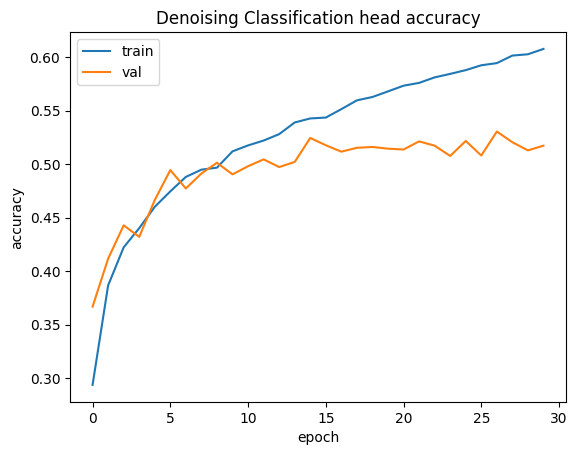

In [ ]:
from matplotlib import pyplot as plt
plt.plot(h.history['classification_head_accuracy'])
plt.plot(h.history['val_classification_head_accuracy'])
plt.title('Denoising Classification head accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'val'], loc='upper left')
plt.show()

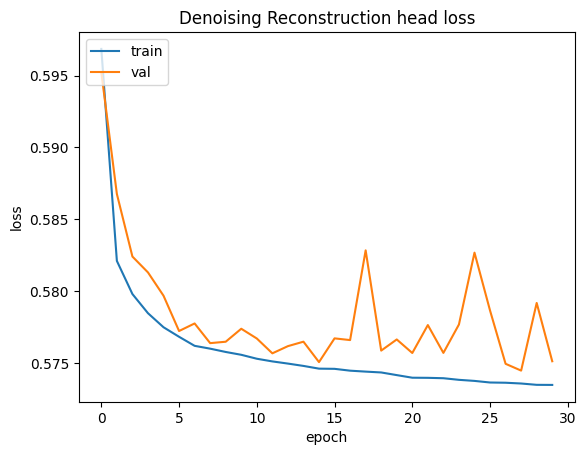

In [ ]:
from matplotlib import pyplot as plt
plt.plot(h.history['reconstruction_head_loss'])
plt.plot(h.history['val_reconstruction_head_loss'])
plt.title('Denoising Reconstruction head loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'val'], loc='upper left')
plt.show()

In [ ]:
features = encoder(x_train[:20000])

In [ ]:
pred = model.predict(x_test)

313/313 [==============================] - 1s 3ms/step


In [ ]:
pred[1].shape

(10000, 10)

In [ ]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score

clf = RandomForestClassifier(max_depth=10, random_state=0)
clf.fit(features, y_train[:20000].ravel())

RandomForestClassifier(max_depth=10, random_state=0)

In [ ]:
features_test = encoder(x_test)

In [ ]:
y_pred = clf.predict(features_test)

In [ ]:
accuracy_score(y_test, y_pred)

0.4642

In [ ]:
accuracy_score(y_test, onehot_to_label(pred[1]))

0.5117

In [ ]:
y_test.shape

(10000, 1)